In [1]:
import gc

import pandas as pd
import  mbr_kernel as mkn
import numpy as np
import utilitaires_810 as u810

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn

from sklearn.feature_selection import SelectKBest, f_classif

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'

# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.1 * faux_pos + faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)


In [2]:
def transform_X(X):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X

In [3]:
import custom_kernel_RefOC as coc

In [4]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input = df_train, df_folder=INPUT_FOLDER)

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 17)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 7s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 21s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 14s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s


In [5]:
# df.to_csv('./processed_data/advanced_FE.csv')

In [6]:
# u810.missing_values_table(df)

In [7]:
# df['BURO_AMT_ANNUITY_MEAN'].describe()

In [8]:
# df[df['BURO_AMT_ANNUITY_MEAN']==0]

In [9]:
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

In [10]:
Xt = transform_X(X)
bestfeatures = SelectKBest(f_classif, k=30)
fit = bestfeatures.fit(Xt,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                          Specs        Score
8                  EXT_SOURCE_3  5786.883295
7                  EXT_SOURCE_2  5202.561997
6                  EXT_SOURCE_1  2720.374075
15        BURO_DAYS_CREDIT_MEAN  1446.144079
1                    DAYS_BIRTH  1131.801448
48            CC_LIMIT_USE_MEAN  1108.324727
10        CREDIT_TO_GOODS_RATIO  1027.591502
2                 DAYS_EMPLOYED   859.751649
20          BURO_HAS_CREDIT_SUM   826.477638
29  PREV_HAD_LATE_PAYMENTS_MEAN   814.390437


/home/maximorose/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/maximorose/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [11]:
featureScores.nlargest(15,'Score')

,Specs,Score
8,EXT_SOURCE_3,5786.883295
7,EXT_SOURCE_2,5202.561997
6,EXT_SOURCE_1,2720.374075
15,BURO_DAYS_CREDIT_MEAN,1446.144079
1,DAYS_BIRTH,1131.801448
48,CC_LIMIT_USE_MEAN,1108.324727
10,CREDIT_TO_GOODS_RATIO,1027.591502
2,DAYS_EMPLOYED,859.751649
20,BURO_HAS_CREDIT_SUM,826.477638
29,PREV_HAD_LATE_PAYMENTS_MEAN,814.390437


In [12]:
top_feat_list = featureScores.nlargest(15,'Score')['Specs'].values

In [13]:
smdf = Xt[top_feat_list]
smdf.shape

(219656, 15)

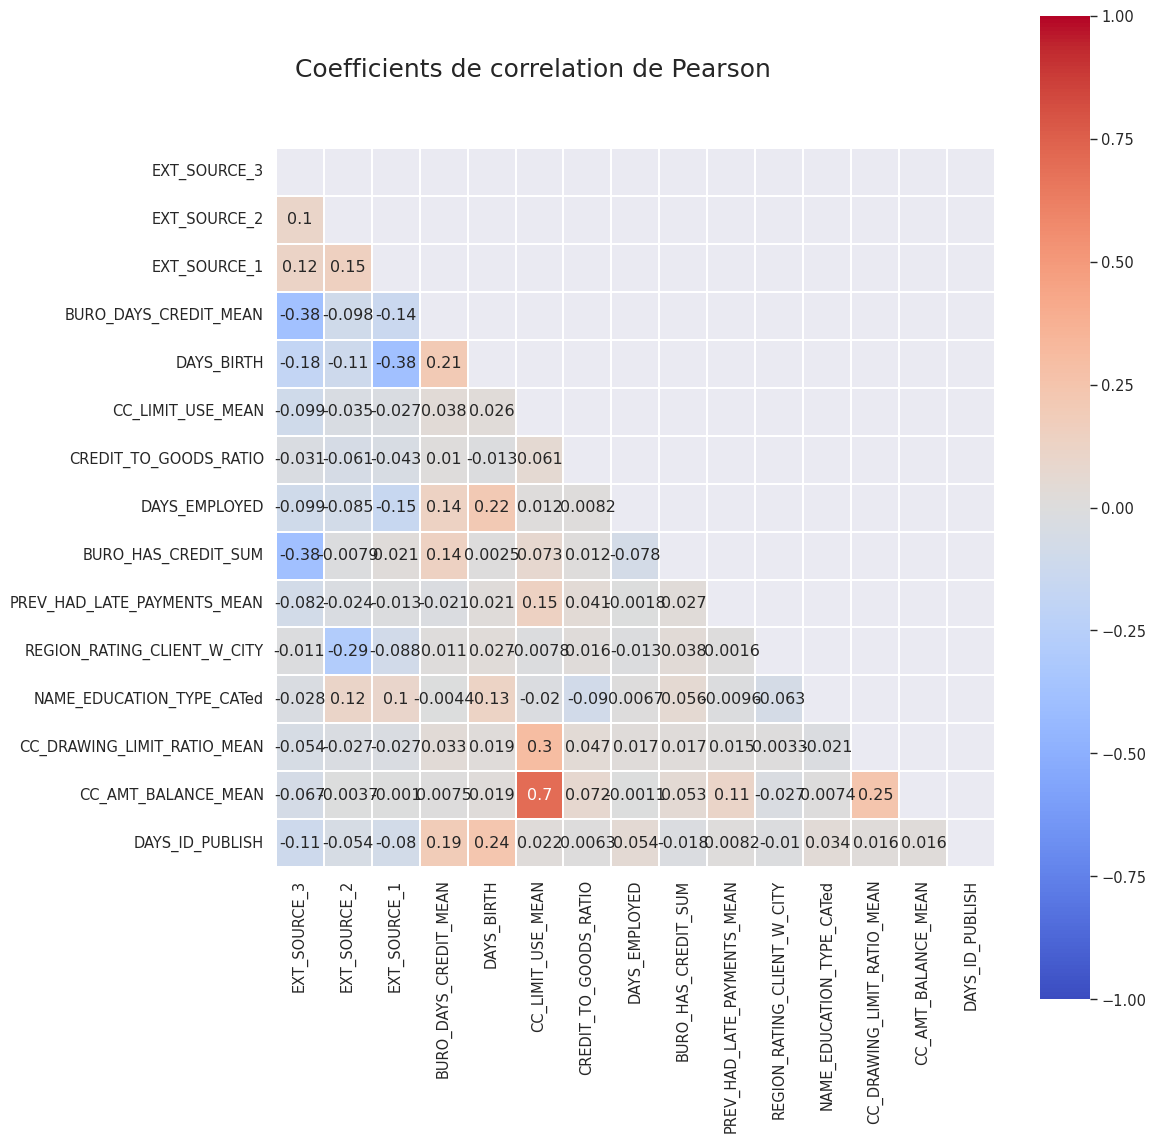

In [14]:
corrmat = smdf.corr()
u810.display_corrmat(corrmat)

In [15]:
# Xt['CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MEAN']

In [16]:
threshold = 0.7

In [17]:
globale_corr = Xt.corr()
highly_correlated = globale_corr.abs() > threshold

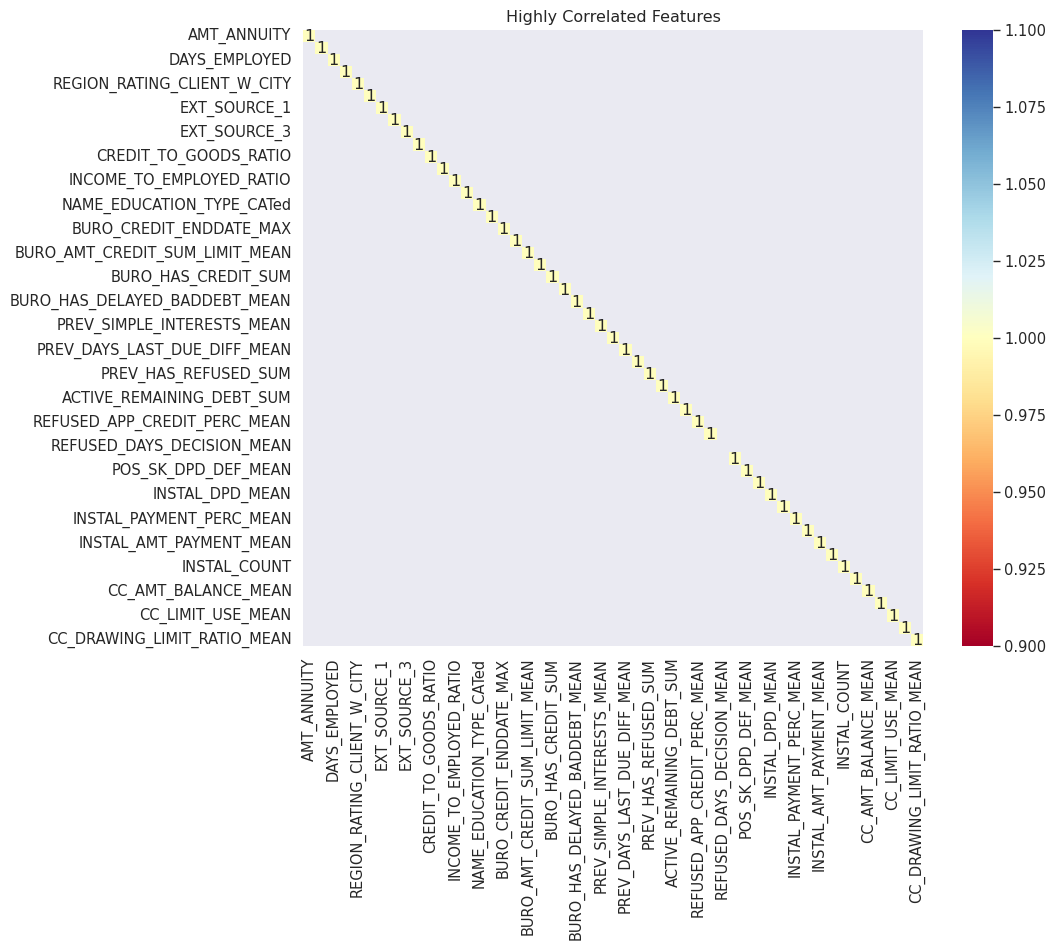

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(globale_corr[highly_correlated], annot=True, cmap="RdYlBu")
plt.title('Highly Correlated Features')
plt.show()

In [19]:
correlation_matrix = globale_corr

# Create an empty dataframe to store the results
correlation_results = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

# Iterate over the highly correlated features
for feature1 in highly_correlated:
    for feature2 in highly_correlated[feature1][highly_correlated[feature1]].index:
        if (feature1 != feature2) & (correlation_results[(correlation_results['Feature 1'] == feature2) & (correlation_results['Feature 2'] == feature1)].shape[0] == 0):  # Exclude self-correlations
            correlation = correlation_matrix.loc[feature1, feature2]
            correlation_results = correlation_results.append({
                'Feature 1': feature1,
                'Feature 2': feature2,
                'Correlation': correlation
            }, ignore_index=True)

# Display the dataframe with highly correlated features
correlation_results

,Feature 1,Feature 2,Correlation


In [20]:
# On ne va garder que l'AMT_CREDIT
featureScores[featureScores['Specs'].isin(['REFUSED_APP_CREDIT_PERC_MEAN', 'REFUSED_DAYS_DECISION_MEAN'])]

,Specs,Score
32,REFUSED_APP_CREDIT_PERC_MEAN,343.625198
34,REFUSED_DAYS_DECISION_MEAN,NaN


check BURO_AMT_CREDIT_SUM_DEBT_MEAN

In [21]:
# On ne va garder que l'AMT_CREDIT
featureScores[featureScores['Specs'].isin(['NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working'])]

,Specs,Score
